In [1]:
# Initial imports
import os
import numpy as np
import requests
import pandas as pd


import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame
%matplotlib inline
import datetime as dt
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
#!pip install oauth2 library
import seaborn as sns
from nsepy import get_history as gh
plt.style.use('fivethirtyeight')
from pandas_datareader import data as web

#!pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting


In [6]:
# CREATE PORTAFOLIO
### Add your portafolio, enter the how many stocks and crypto you want to add to your portafolio analizer
### enter the name, the amount or shares and the price paid for the asset.

stock_inputs= int(input("Enter the amount of stock youll like to analyze"))
stock_dic = {}
for i in range(stock_inputs):
    stocks_name = input("Enter the ticker name of your assets").split()
    stocks_amount = input("Enter the amount of shares that you own").split()
    stocks_price = input("Enter the amount you paid for your shares").split()
    name_key = stocks_name[0]
    amount_key = stocks_amount[0]
    price_key = stocks_price[0]
    stock_dic[name_key.upper()] = [float(amount_key), float(price_key)]

Enter the amount of stock youll like to analyze 1
Enter the ticker name of your assets 1
Enter the amount of shares that you own 1
Enter the amount you paid for your shares 1


In [7]:
##create a DataFrame from the dictionary.12
stocks_portfolio = pd.DataFrame.from_dict(stock_dic, orient='index')
stocks_portfolio.columns=['Shares', 'Price']    
#weights = 
stocks_portfolio = stocks_portfolio.rename_axis('symbol')
stocks_portfolio["portfolio_value"] = (stocks_portfolio.Shares * stocks_portfolio.Price).sum()
stocks_portfolio["price_shares_by_symbol"] = (stocks_portfolio.Shares * stocks_portfolio.Price)
stocks_portfolio["weights"] = (stocks_portfolio.Price / stocks_portfolio.portfolio_value) * 100

display(stocks_portfolio)
numpy_array = stocks_portfolio.weights.to_numpy()

print(numpy_array)

print(type(numpy_array))

,Shares,Price,portfolio_value,price_shares_by_symbol,weights
symbol,,,,,
1,1.0,1.0,1.0,1.0,100.0


[100.]
<class 'numpy.ndarray'>


In [8]:
##get the tiker 

###FAANG 

assets = ["META","AMZN","AAPL", "NFLX","GOOG"]

weights = np.array([0.2,0.2,0.2,0.2,0.2])

#get statt date
stockStartDate = "2008-01-01"

today = datetime.today().strftime("%y-%m-%d")

stocks_df = pd.DataFrame()

for stock in assets:
    stocks_df[stock] = web.DataReader(stock, data_source="yahoo", start=stockStartDate,end="2022-04-07")["Adj Close"]

,META,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2021-06-29,15.07,3448.139893,135.754700,533.500000,2520.370117
2021-06-30,15.12,3440.159912,136.382050,528.210022,2506.320068
2021-07-01,14.89,3432.969971,136.690750,533.539978,2527.370117
2021-07-02,15.00,3510.979980,139.369400,533.979980,2574.379883
2021-07-06,15.01,3675.739990,141.420715,541.640015,2595.419922


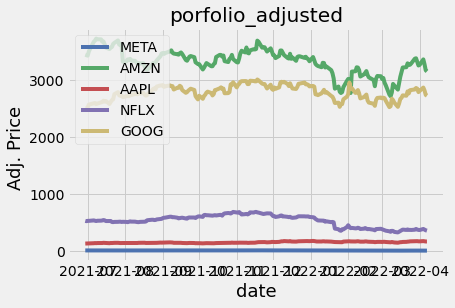

In [9]:
##visualisce stock close
title = "porfolio_adjusted"
my_stocks = stocks_df

for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label=c)
plt.title(title)
plt.xlabel("date", fontsize = 18, )
plt.ylabel("Adj. Price ", fontsize=18)
plt.legend(my_stocks.columns.values,loc="upper left")
stocks_df.head()

In [10]:
returns = stocks_df.pct_change()
##variance = messure of how mucha aset of observetion differ from one 
cov_matrix_annual = returns.cov() * 252
por_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
por_vol = np.sqrt(por_variance)
port_simple_annual_ret = np.sum(returns.mean() * weights) ** 252
print("_____________________________________________________________")
print(f"this is the analys of this portfolio usinf this weights: {numpy_array}")

_____________________________________________________________
this is the analys of this portfolio usinf this weights: [100.]


In [644]:
percent_var = str(round(por_variance, 2) * 100) + "%"
percent_vols = str(round(por_vol, 2) * 100) + "%"
percent_ret = str(round(port_simple_annual_ret, 2) * 100) + "%"


print("expected annual return:" + percent_ret)
print("annual volatility/ risk:"+ percent_vols)
print("annual variance:" + percent_var)

expected annual return:0.0%
annual volatility/ risk:26.0%
annual variance:7.000000000000001%


Text(0, 0.5, 'Expected Return')

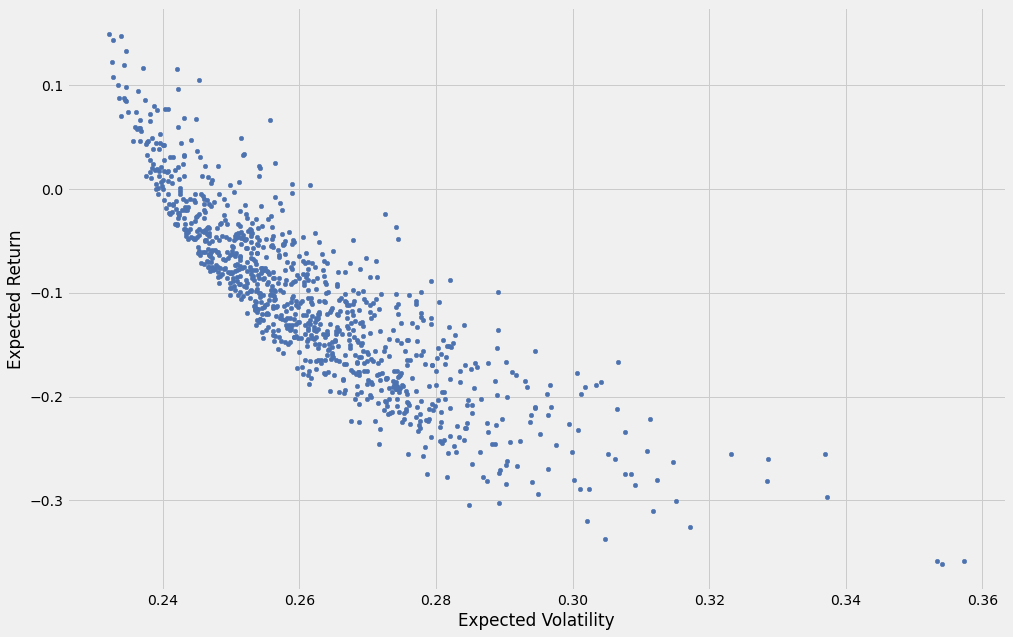

In [11]:
##calculate the expected returns and the annualized sample of nht ematrix asser returns
log_returns = np.log(stocks_df/stocks_df.shift(1))

log_returns.mean() * 250
log_returns.cov() * 250

log_returns.corr()

#Here we are creating a 1000 different portfolio variations

portfolio_returns = []
portfolio_volatilities = []
for x in range(1000):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    
    portfolio_returns.append(np.sum(weights * log_returns.mean()) * 250)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 250, weights))))
                    
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)
                                  


np.sum(weights * log_returns.mean()) * 250

np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 250, weights)))

portfolios = pd.DataFrame({'Return': portfolio_returns, 'Volatility':portfolio_volatilities  })
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(15,10));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')



In [12]:
##portfolio optimization using PyPortfolioOpt

mu = expected_returns.mean_historical_return(stocks_df)
s = risk_models.sample_cov(stocks_df)

##optimized for max sharpe ratio

ef = EfficientFrontier(mu, s, weight_bounds=(None,None))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


print(f"This is the best portfolio allocation posible {cleaned_weights}")

Expected annual return: 79.5%
Annual volatility: 33.2%
Sharpe Ratio: 2.33
This is the best portfolio allocation posible OrderedDict([('META', -0.89363), ('AMZN', 0.08549), ('AAPL', 1.0), ('NFLX', -0.19186), ('GOOG', 1.0)])


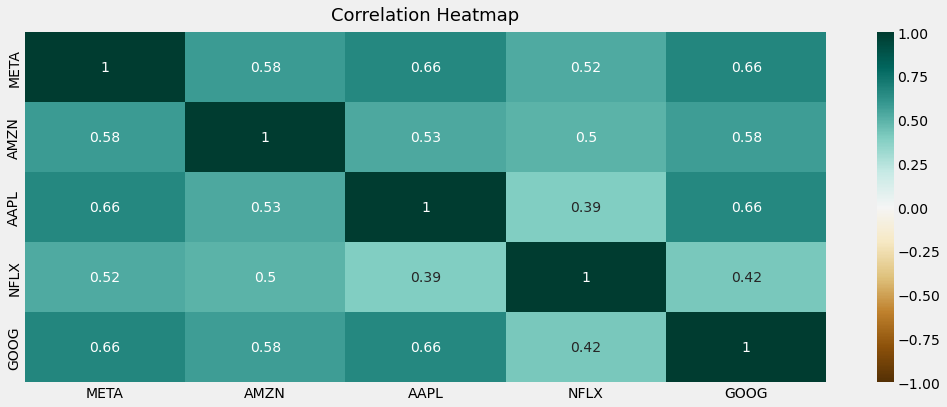

In [13]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(returns.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [14]:
##get discrete allocation 
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
total = stocks_portfolio.portfolio_value.sum()
total = int(total)


In [17]:
latest_prices = get_latest_prices(stocks_df)
weights = cleaned_weights 
da = DiscreteAllocation(cleaned_weights,latest_prices,total_portfolio_value=total)

allocation, leftover = da.greedy_portfolio(reinvest=True, verbose=True)
print("discrete allocation: ", allocation)
print("funds remaining: ${:.2f}".format(leftover))


Allocating long sub-portfolio...

Allocating short sub-portfolio...
discrete allocation:  {}
funds remaining: $3.17


In [18]:
display(stocks_df)
display(weights_df)
display(stocks_portfolio)


,META,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2021-06-29,15.07,3448.139893,135.754700,533.500000,2520.370117
2021-06-30,15.12,3440.159912,136.382050,528.210022,2506.320068
2021-07-01,14.89,3432.969971,136.690750,533.539978,2527.370117
2021-07-02,15.00,3510.979980,139.369400,533.979980,2574.379883
2021-07-06,15.01,3675.739990,141.420715,541.640015,2595.419922
...,...,...,...,...,...
2022-04-01,11.95,3271.199951,174.309998,373.470001,2814.000000
2022-04-04,12.44,3366.929932,178.440002,391.500000,2872.850098
2022-04-05,12.05,3281.100098,175.059998,380.149994,2821.260010


NameError: name 'weights_df' is not defined

In [22]:
stocks_df.isnull().sum().sum() 
stocks_df = stocks_df.fillna(method = "pad")

In [23]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and thtotal_porfolio_valueget (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [27]:
# Create the features (X) and target (y) data using the window_data() function.

window_size = 30

feature_column = 2
target_column = 4
X, y = window_data(stocks_df, window_size, feature_column, target_column)

In [28]:
# Print a few sample values from X and y
#print (f"X sample values:\n{X[:5]} \n")
#print (f"y sample values:\n{y[:5]}")


split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [29]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [30]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
#print (f"X_train sample values:\n{X_train[:3]} \n")
#print (f"X_test sample values:\n{X_test[:3]}")

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [32]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 3
dropout_fraction = 0.6
# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [33]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [34]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 3)             60        
                                                                 
 dropout (Dropout)           (None, 30, 3)             0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 3)             84        
                                                                 
 dropout_1 (Dropout)         (None, 30, 3)             0         
                                                                 
 lstm_2 (LSTM)               (None, 3)                 84        
                                                                 
 dropout_2 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=100, shuffle=True, batch_size=1, verbose=0)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

In [ ]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()}, index = stocks_df.index[-len(real_prices): ])
stocks.head()

In [ ]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted stocks Price")

###SENTIMENT ANALYSIS

In [ ]:
import os
import pandas as pd
from newsapi.newsapi_client import NewsApiClient
from alpaca_trade_api.rest import REST, TimeFrame
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk as nltk
nltk.download('vader_lexicon')
import json
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from collections import Counter
nltk.download("stopwords")
#nltk.downlaod("punkt")
from dotenv import load_dotenv
lemmatizer = WordNetLemmatizer()
import datetime as dt
#!python -m spacy download en_core_web_sm
import spacy
from spacy import displacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [ ]:


load_dotenv("key.env")
api_key = os.getenv("NEWS_API_KEY")
newsapi = NewsApiClient(api_key=api_key)

assets = ["META","AMZN","AAPL", "NFLX","GOOG"]


    
 





all_articles = newsapi.get_everything(q="assets",
                                          sources='bbc-news,the-verge',
                                          domains='bbc.co.uk,techcrunch.com',
                                          from_param='2020-00-01',
                                          to='2022-04-01',
                                          language='en',
                                          sort_by='relevancy')



In [ ]:
sid = SentimentIntensityAnalyzer()
# Create the portfolio sentiment scores DataFrame
portfolio_sentiments = []

analyzer = SentimentIntensityAnalyzer()

for article in all_articles["articles"]:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        portfolio_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
portfolio_sentiments_df = pd.DataFrame(portfolio_sentiments)

# Reorder DataFrame columns
cols = ["date", "text", "compound", "positive", "negative", "neutral"]

portfolio_sentiments_df = portfolio_sentiments_df[cols]



In [ ]:
portfolio_sentiments_df

In [ ]:
# Correlate the headlines' sentiment to returns
portfolio_sentiments_df.corr().style.background_gradient()

In [696]:
portfolio_sentiments_df.describe()

,compound,positive,negative,neutral
count,20.000000,20.000000,20.000000,20.000000
mean,0.027415,0.061700,0.055150,0.883150
std,0.428161,0.070163,0.065563,0.095385
min,-0.796400,0.000000,0.000000,0.668000
25%,-0.200375,0.000000,0.000000,0.822750
50%,0.000000,0.055000,0.041500,0.881500
75%,0.243725,0.097000,0.085500,0.962500
max,0.855500,0.233000,0.191000,1.000000


In [697]:
##generate a wordcloud funtion("I tried adding a bi-gram counter but i could not do it do to the datatypes"
def word_cloud_tokenizer(text):
    str_text = json.dumps(all_articles)
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', str_text)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw]
    big_string = ' '.join(output)
    wc = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(big_string)
    plot = plt.imshow(wc,interpolation='bilinear')
    plt.axis("off")
    return plot

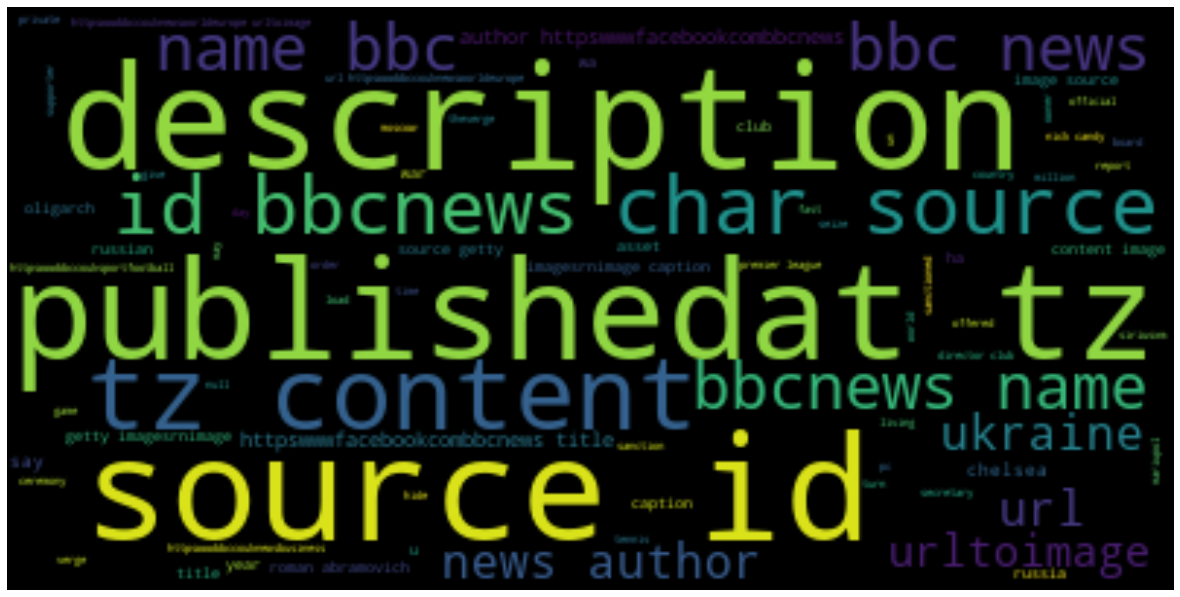

In [698]:
word_cloud_tokenizer(all_articles)

In [699]:
# Load the spaCy model

def most_commun_describers(text): 
    """making a funtion to get the a list of the most 
    comunt adjetive and plot a wordcloud of those words
    to easy visialisation
    as the input it takes a json files as the text""" 
    nlp = spacy.load('en_core_web_sm')
    all_bitcoin_sentences = json.dumps(text)
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', all_bitcoin_sentences)
    sw = set(stopwords.words('english'))
    new_bitcoin_tokens = nlp(re_clean)
    #displacy.render(new_bitcoin_tokens, style="ent")
    adjs = [token.text.lower() for token in new_bitcoin_tokens if token.pos_ == 'ADJ']
    most_freq_adjectives = Counter(adjs).most_common(50)
    #print(most_freq_adjectives)
    str_freq_adjs = json.dumps(most_freq_adjectives)
    wc = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(str_freq_adjs)
    plot = plt.imshow(wc,interpolation='bilinear')
    plt.axis("off")
    return plot

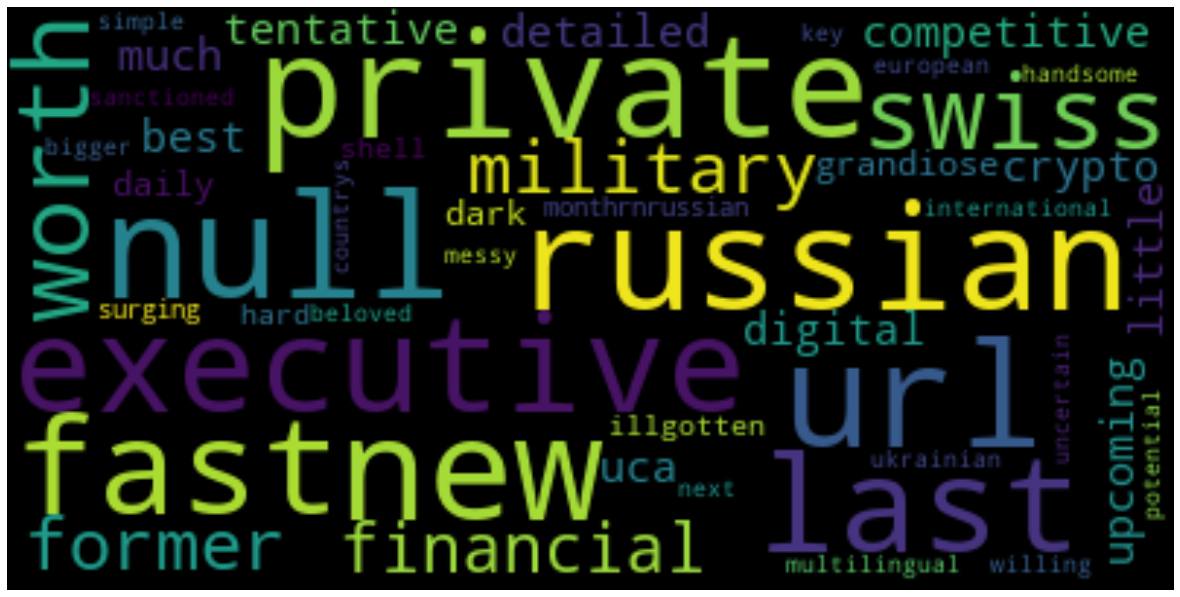

In [700]:
most_commun_describers(all_articles)

In [ ]:
# Function token_count generates the top 10 words for a given coin
# Complete the tokenizer function
def tokenizer(text):
    str_text = json.dumps(all_articles)
  # Remove the stop words
    sw = set(stopwords.words('english'))
  # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', str_text)
  # Create a tokenized list of the words
    words = word_tokenize(re_clean)
  # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
  # Convert the words to lowercase
    output = [word.lower() for word in lem if word.lower() not in sw]

    return output
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(10)


In [ ]:
print(token_count(tokenizer(all_articles)))